In [ ]:
# --- FOR DATA PREPROCESSING AND CLASS IMBALANCE ---

In [1]:
import shutil
import json
import yaml
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict

In [2]:
PROJECT_ROOT = Path("..").resolve()

# DATA SOURCES
TRAIN_SRC = PROJECT_ROOT / "images_thermal_train"   # contains image data and coco.json
VAL_SRC   = PROJECT_ROOT / "images_thermal_val"     # contains image data and coco.json

# Destination paths for YOLO structure
IMAGES_DIR = PROJECT_ROOT / "images"
LABELS_DIR = PROJECT_ROOT / "labels"

# CONFIG File
CONFIG_YAML = PROJECT_ROOT / "config.yml"

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp")
SKIP_EXISTING = True   # set False for a full clean rebuild
VERIFY_FILES  = True

# ---------------------------------------------------------------------------
# CLASS MERGE MAP  (source dataset name -> new unified name)
# The dataset hardcodes these names; we remap at conversion time so the
# processed labels always reflect the final config.yml class list.
#
#   DROPPED  : scooter, dog  -> mapped to None -> annotation skipped
#   MERGED   : bike + motor  -> two_wheeler
#              bus  + truck  -> large_vehicle
#   UNCHANGED: person, car, light, sign
# ---------------------------------------------------------------------------
MERGE_MAP = {
    # merge into two_wheeler
    'bike':    'two_wheeler',
    'motor':   'two_wheeler',
    # merge into large_vehicle
    'bus':     'large_vehicle',
    'truck':   'large_vehicle',
    # drop entirely (map to None)
    'scooter': None,
    'dog':     None,
    # pass-through (unchanged)
    'person':  'person',
    'car':     'car',
    'light':   'light',
    'sign':    'sign',
}

In [3]:
# --- MAKING THE YOLO DIRECTORY STRUCTURE ---
def make_yolo_dirs():
    for split in ('train', 'val'):
        (IMAGES_DIR / split).mkdir(parents=True, exist_ok=True)
        (LABELS_DIR / split).mkdir(parents=True, exist_ok=True)

make_yolo_dirs()
print("✓ YOLO directory structure ready")

✓ YOLO directory structure ready


In [4]:
# --- COPY IMAGES TO YOLO DIRECTORIES ---
def copy_images(src_dataset_dir: Path, split: str):
    src_img_dir = src_dataset_dir / "data"
    dst_img_dir = IMAGES_DIR / split

    if dst_img_dir.exists() and not SKIP_EXISTING:
        shutil.rmtree(dst_img_dir)
        dst_img_dir.mkdir(parents=True, exist_ok=True)

    files = sorted([p for p in src_img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
    copied, skipped = 0, 0

    for p in files:
        dst = dst_img_dir / p.name
        if SKIP_EXISTING and dst.exists():
            skipped += 1
            continue
        shutil.copy2(p, dst)
        copied += 1

    print(f"{split}: copied {copied} images" + (f" (skipped {skipped})" if skipped else ""))
    return [p.name for p in files]

train_image_files = copy_images(TRAIN_SRC, "train")
val_image_files   = copy_images(VAL_SRC,   "val")

print(f"\nTotal training images : {len(train_image_files)}")
print(f"Total val images      : {len(val_image_files)}")

train: copied 10742 images
val: copied 1144 images

Total training images : 10742
Total val images      : 1144


In [5]:
# --- LOAD CLASS NAMES FROM config.yml ---
def load_names_from_config(config_path: Path):
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    return [str(n).lower().strip() for n in cfg["names"]]


# --- CONVERT COCO JSON -> YOLO LABELS ---
# Applies MERGE_MAP at annotation time:
#   - dropped classes (None)  : annotation silently skipped
#   - merged classes          : remapped to unified name before index lookup
#   - unchanged classes       : looked up directly in config.yml names
def coco_to_yolo_labels(src_dataset_dir: Path, split: str, image_files_filter=None):
    coco_path = src_dataset_dir / "coco.json"
    assert coco_path.exists(), f"Missing {coco_path}"

    names       = load_names_from_config(CONFIG_YAML)
    name_to_idx = {n: i for i, n in enumerate(names)}

    with open(coco_path, "r") as f:
        data = json.load(f)

    # Build category_id -> yolo_class_idx, applying MERGE_MAP
    catid_to_idx = {}      # category_id -> final yolo index
    skipped_cats  = []     # categories intentionally dropped
    unmatched_cats = []    # categories not in MERGE_MAP at all

    for cat in data["categories"]:
        cname = str(cat["name"]).lower().strip()

        if cname in MERGE_MAP:
            target = MERGE_MAP[cname]          # None = drop
            if target is None:
                skipped_cats.append(cname)     # intentionally dropped
            elif target in name_to_idx:
                catid_to_idx[cat["id"]] = name_to_idx[target]
            else:
                # MERGE_MAP points to a name not in config.yml — config mismatch
                print(f"  ⚠ MERGE_MAP target '{target}' not found in config.yml — check config!")
        else:
            # Category exists in dataset but not mentioned in MERGE_MAP at all
            unmatched_cats.append(cname)

    if skipped_cats:
        print(f"  [DROPPED]   {split}: {sorted(set(skipped_cats))}")
    if unmatched_cats:
        print(f"  [UNMATCHED] {split}: {sorted(set(unmatched_cats))} (not in MERGE_MAP, skipped)")

    # Build image lookup
    images = {img["id"]: img for img in data["images"]}

    if image_files_filter is not None:
        keep   = set(image_files_filter)
        images = {iid: info for iid, info in images.items()
                  if Path(info["file_name"]).name in keep}

    # Group annotations by image_id
    ann_by_img = defaultdict(list)
    for anno in data["annotations"]:
        if anno["image_id"] in images:
            ann_by_img[anno["image_id"]].append(anno)

    dst_label_dir = LABELS_DIR / split
    if dst_label_dir.exists() and not SKIP_EXISTING:
        shutil.rmtree(dst_label_dir)
        dst_label_dir.mkdir(parents=True, exist_ok=True)

    processed = 0
    empty     = 0
    dropped_boxes = 0

    for img_id, img_info in images.items():
        img_w, img_h = img_info["width"], img_info["height"]
        img_name     = Path(img_info["file_name"]).name
        label_name   = Path(img_name).with_suffix(".txt").name
        out_path     = dst_label_dir / label_name

        if SKIP_EXISTING and out_path.exists():
            processed += 1
            continue

        lines = []
        for anno in ann_by_img.get(img_id, []):
            cid = anno["category_id"]

            # Skip if category not mapped (dropped or unmatched)
            if cid not in catid_to_idx:
                continue

            x, y, bw, bh = anno["bbox"]

            # Skip degenerate boxes
            if bw <= 0 or bh <= 0:
                dropped_boxes += 1
                continue

            # Convert to YOLO normalised format
            xc   = (x + bw / 2.0) / img_w
            yc   = (y + bh / 2.0) / img_h
            bw_n = bw / img_w
            bh_n = bh / img_h

            # Skip boxes outside valid normalised range
            if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 < bw_n <= 1 and 0 < bh_n <= 1):
                dropped_boxes += 1
                continue

            cls = catid_to_idx[cid]
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {bw_n:.6f} {bh_n:.6f}\n")

        out_path.write_text("".join(lines))
        if len(lines) == 0:
            empty += 1
        processed += 1

    print(f"✓ {split}: wrote {processed} label files | {empty} empty | {dropped_boxes} invalid boxes dropped")


print("Converting train...")
coco_to_yolo_labels(TRAIN_SRC, "train", image_files_filter=train_image_files)
print("Converting val...")
coco_to_yolo_labels(VAL_SRC,   "val",   image_files_filter=val_image_files)

Converting train...
  [DROPPED]   train: ['dog', 'scooter']
  [UNMATCHED] train: ['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bird', 'boat', 'bottle', 'bowl', 'broccoli', 'cake', 'carrot', 'cat', 'cell phone', 'chair', 'couch', 'cow', 'cup', 'deer', 'dining table', 'donut', 'elephant', 'face', 'fork', 'frisbee', 'giraffe', 'handbag', 'hot dog', 'hydrant', 'keyboard', 'kite', 'knife', 'laptop', 'license plate', 'microwave', 'mouse', 'orange', 'other vehicle', 'oven', 'parking meter', 'pizza', 'potted plant', 'remote', 'rider', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stroller', 'suitcase', 'surfboard', 'tennis racket', 'tie', 'toaster', 'toilet', 'train', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra'] (not in MERGE_MAP, skipped)
✓ train: wrote 10742 label files | 271 empty | 0 invalid boxes dropped
Converting val...
  [DROPPED]   val: ['dog', 'scooter']
  [UNMATCHED] v

In [6]:
# --- VERIFY IMAGE / LABEL PAIRS ---
def verify_pairs(split: str):
    img_dir = IMAGES_DIR / split
    lbl_dir = LABELS_DIR / split

    img_stems = {p.stem for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS}
    lbl_stems = {p.stem for p in lbl_dir.iterdir() if p.suffix.lower() == ".txt"}

    missing_labels = img_stems - lbl_stems
    missing_images = lbl_stems - img_stems

    if missing_labels:
        print(f"⚠ {split}: {len(missing_labels)} images without labels (examples: {list(missing_labels)[:5]})")
    if missing_images:
        print(f"⚠ {split}: {len(missing_images)} labels without images (examples: {list(missing_images)[:5]})")
    if not missing_labels and not missing_images:
        print(f"✓ {split}: all {len(img_stems)} images have matching labels")

if VERIFY_FILES:
    verify_pairs("train")
    verify_pairs("val")

✓ train: all 10742 images have matching labels
✓ val: all 1144 images have matching labels


In [7]:
# --- CLASS COUNTS FROM YOLO LABELS ---
def class_counts_from_yolo_labels(label_dir: Path, names):
    counts          = Counter()
    images_with_cls = Counter()

    for txt in label_dir.glob("*.txt"):
        lines   = txt.read_text().strip().splitlines()
        present = set()
        for ln in lines:
            if not ln.strip():
                continue
            cls = int(ln.split()[0])
            counts[cls] += 1
            present.add(cls)
        for cls in present:
            images_with_cls[cls] += 1

    # Ensure all classes appear even with 0 count
    for i in range(len(names)):
        counts[i]          += 0
        images_with_cls[i] += 0

    return counts, images_with_cls


names = load_names_from_config(CONFIG_YAML)

train_counts, train_imgfreq = class_counts_from_yolo_labels(LABELS_DIR / "train", names)
val_counts,   val_imgfreq   = class_counts_from_yolo_labels(LABELS_DIR / "val",   names)

# Sort by train count descending
order  = sorted(range(len(names)), key=lambda i: train_counts[i], reverse=True)
labels = [names[i] for i in order]

print("Class summary (train | val):")
print(f"{'Class':<16} {'Train inst':>11} {'Train imgs':>11} {'Val inst':>9} {'Val imgs':>9}")
print("-" * 60)
for i in order:
    print(f"{names[i]:<16} {train_counts[i]:>11,} {train_imgfreq[i]:>11,} "
          f"{val_counts[i]:>9,} {val_imgfreq[i]:>9,}")
print("-" * 60)
print(f"{'TOTAL':<16} {sum(train_counts.values()):>11,} "
      f"{'':>11} {sum(val_counts.values()):>9,}")

Class summary (train | val):
Class             Train inst  Train imgs  Val inst  Val imgs
------------------------------------------------------------
car                   73,623       9,824     7,133     1,047
person                50,478       8,205     4,470       819
sign                  20,770       6,802     2,472       848
light                 16,198       3,695     2,005       439
two_wheeler            8,353       3,670       225       178
large_vehicle          3,074       1,860       225       161
------------------------------------------------------------
TOTAL                172,496                16,530


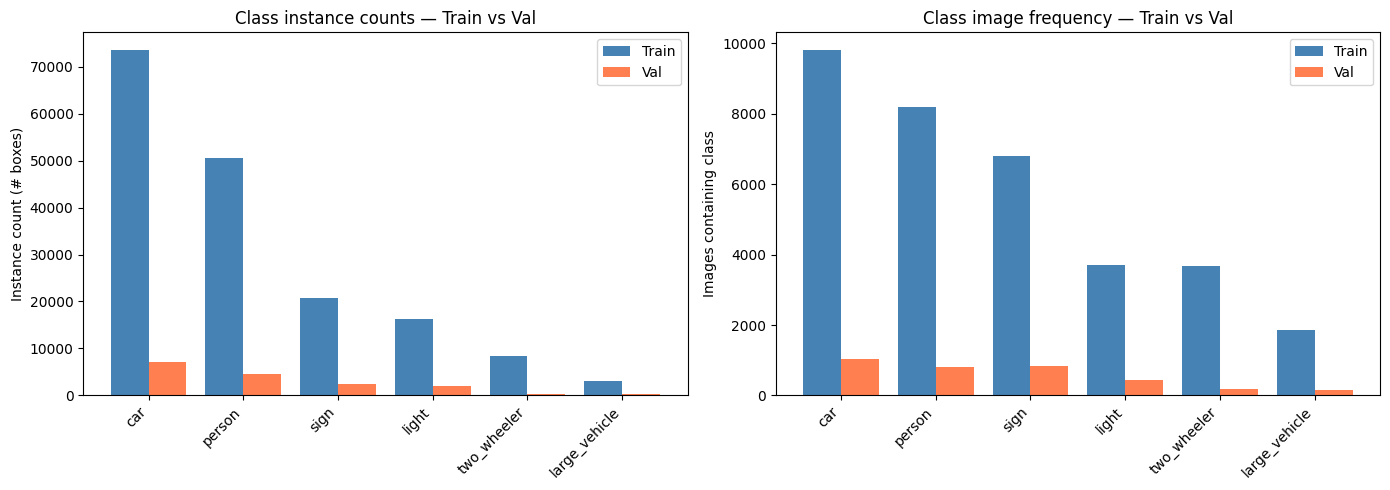

In [8]:
# --- PLOT: INSTANCE COUNTS TRAIN vs VAL (SIDE BY SIDE) ---
x      = np.arange(len(labels))
width  = 0.4

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Instance counts
train_vals = [train_counts[i] for i in order]
val_vals   = [val_counts[i]   for i in order]

axes[0].bar(x - width/2, train_vals, width, label='Train', color='steelblue')
axes[0].bar(x + width/2, val_vals,   width, label='Val',   color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=45, ha='right')
axes[0].set_ylabel('Instance count (# boxes)')
axes[0].set_title('Class instance counts — Train vs Val')
axes[0].legend()

# Image frequency
train_imgv = [train_imgfreq[i] for i in order]
val_imgv   = [val_imgfreq[i]   for i in order]

axes[1].bar(x - width/2, train_imgv, width, label='Train', color='steelblue')
axes[1].bar(x + width/2, val_imgv,   width, label='Val',   color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=45, ha='right')
axes[1].set_ylabel('Images containing class')
axes[1].set_title('Class image frequency — Train vs Val')
axes[1].legend()

plt.tight_layout()
plt.show()

Bounding box area statistics (normalised, 1.0 = full image):
  Total boxes          : 172,496
  Median area          : 0.095% of image
  Mean area            : 0.541% of image
  Boxes < 0.1% image   : 88,151  (51.1%)  ← likely tiny/noise
  Boxes < 0.5% image   : 139,344  (80.8%)
  Boxes > 25% image    : 102   (0.1%)  ← close-range / large objects


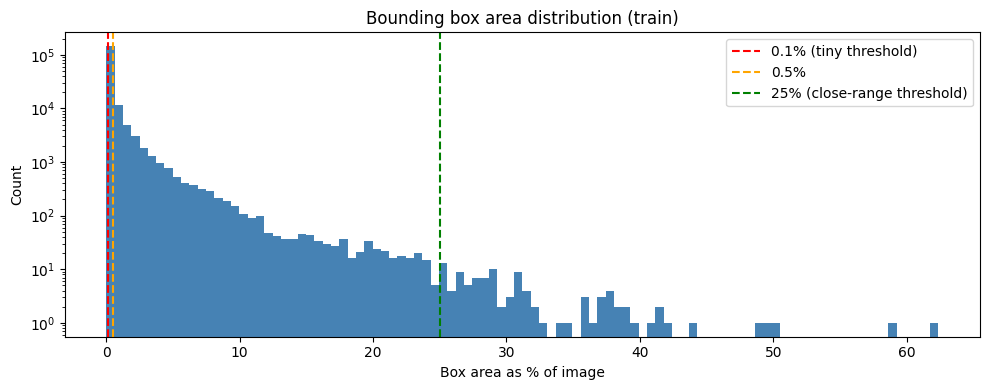

In [9]:
# --- BOUNDING BOX SIZE DISTRIBUTION (catches tiny/bad annotations) ---
areas = []
for txt in (LABELS_DIR / "train").glob("*.txt"):
    for ln in txt.read_text().splitlines():
        parts = ln.strip().split()
        if len(parts) == 5:
            bw, bh = float(parts[3]), float(parts[4])
            areas.append(bw * bh)

areas = np.array(areas)
print("Bounding box area statistics (normalised, 1.0 = full image):")
print(f"  Total boxes          : {len(areas):,}")
print(f"  Median area          : {np.median(areas)*100:.3f}% of image")
print(f"  Mean area            : {np.mean(areas)*100:.3f}% of image")
print(f"  Boxes < 0.1% image   : {(areas < 0.001).sum():,}  ({(areas < 0.001).mean()*100:.1f}%)  ← likely tiny/noise")
print(f"  Boxes < 0.5% image   : {(areas < 0.005).sum():,}  ({(areas < 0.005).mean()*100:.1f}%)")
print(f"  Boxes > 25% image    : {(areas > 0.25).sum():,}   ({(areas > 0.25).mean()*100:.1f}%)  ← close-range / large objects")

plt.figure(figsize=(10, 4))
plt.hist(areas * 100, bins=100, color='steelblue', edgecolor='none')
plt.axvline(0.1,  color='red',    linestyle='--', label='0.1% (tiny threshold)')
plt.axvline(0.5,  color='orange', linestyle='--', label='0.5%')
plt.axvline(25.0, color='green',  linestyle='--', label='25% (close-range threshold)')
plt.xlabel('Box area as % of image')
plt.ylabel('Count')
plt.title('Bounding box area distribution (train)')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

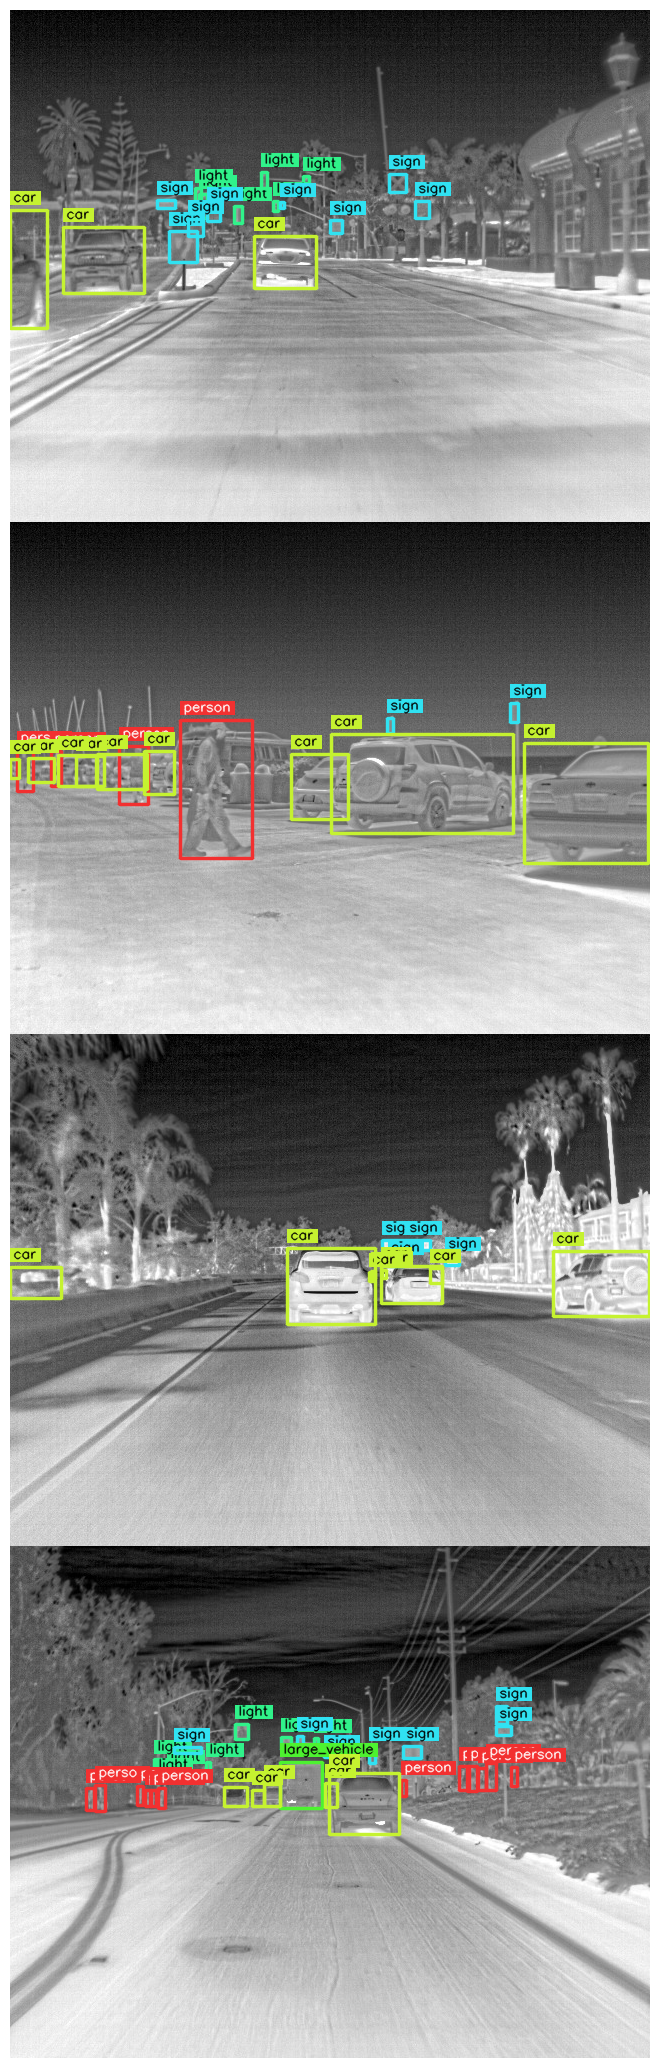

In [12]:
# --- DISPLAY 4 RANDOM TRAINING IMAGES WITH ANNOTATIONS ---
import colorsys

IMG_DIR        = IMAGES_DIR / "train"
LBL_DIR        = LABELS_DIR / "train"
NUM_IMAGES     = 4
MAX_WIDTH      = 1100
DRAW_LABEL_TEXT = True


def class_color_rgb(idx):
    h = (idx * 37) % 360
    r, g, b = colorsys.hsv_to_rgb(h / 360.0, 0.8, 0.95)
    return int(r * 255), int(g * 255), int(b * 255)


def readable_text_color(r, g, b):
    luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255.0
    return (0, 0, 0) if luminance > 0.6 else (255, 255, 255)


def draw_boxes_rgb(img_rgb, label_path, names, draw_labels=True):
    h, w = img_rgb.shape[:2]
    if not label_path.exists():
        return img_rgb
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    for ln in label_path.read_text().splitlines():
        if not ln.strip():
            continue
        parts = ln.split()
        if len(parts) < 5:
            continue
        try:
            cls = int(parts[0])
            xc, yc, bw, bh = map(float, parts[1:5])
        except ValueError:
            continue

        x1 = max(0, min(w - 1, int((xc - bw / 2) * w)))
        y1 = max(0, min(h - 1, int((yc - bh / 2) * h)))
        x2 = max(0, min(w - 1, int((xc + bw / 2) * w)))
        y2 = max(0, min(h - 1, int((yc + bh / 2) * h)))

        r, g, b_c = class_color_rgb(cls)
        color_bgr  = (b_c, g, r)
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color_bgr, thickness=2, lineType=cv2.LINE_AA)

        if draw_labels:
            label_txt  = names[cls] if cls < len(names) else str(cls)
            font       = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = max(0.45, min(1.0, w / 1200.0 * 0.5))
            thickness  = 1 if font_scale < 0.6 else 2
            ts, _      = cv2.getTextSize(label_txt, font, font_scale, thickness)
            pad        = 6
            rect_w     = ts[0] + pad
            rect_h     = ts[1] + pad // 2

            label_y2 = max(0, y1 - 6)
            label_y1 = label_y2 - rect_h
            inside   = False
            if label_y1 < 0:
                label_y1 = y1
                label_y2 = y1 + rect_h
                inside   = True

            label_x1 = x1
            label_x2 = label_x1 + rect_w
            if label_x2 > w:
                label_x2 = w - 1
                label_x1 = label_x2 - rect_w

            cv2.rectangle(img_bgr, (label_x1, label_y1), (label_x2, label_y2), color_bgr, -1)
            tc     = readable_text_color(r, g, b_c)
            tc_bgr = (tc[2], tc[1], tc[0])
            text_y = label_y2 - 4 if inside else label_y2 - 3
            cv2.putText(img_bgr, label_txt, (label_x1 + 3, text_y),
                        font, font_scale, tc_bgr, thickness, cv2.LINE_AA)

    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


# Sample and render
names = load_names_from_config(CONFIG_YAML)
image_files = sorted([p for p in IMG_DIR.iterdir() if p.suffix.lower() in IMG_EXTS])
if not image_files:
    raise FileNotFoundError(f"No images in {IMG_DIR}")

sample_files = random.sample(image_files, min(NUM_IMAGES, len(image_files)))

imgs    = []
heights = []
for p in sample_files:
    bgr = cv2.imread(str(p))
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    if w > MAX_WIDTH:
        scale = MAX_WIDTH / w
        rgb   = cv2.resize(rgb, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    lbl = LBL_DIR / (p.stem + ".txt")
    out = draw_boxes_rgb(rgb, lbl, names, draw_labels=DRAW_LABEL_TEXT)
    imgs.append(out)
    heights.append(out.shape[0])

total_h = sum(heights)
fig_w   = min(MAX_WIDTH, max(im.shape[1] for im in imgs)) / 100.0
fig_h   = total_h / 100.0
fig     = plt.figure(figsize=(fig_w, fig_h))

y_acc = 0
for im in imgs:
    h, w = im.shape[:2]
    ax   = fig.add_axes([0, 1 - (y_acc + h) / total_h, 1, h / total_h])
    ax.imshow(im)
    ax.axis("off")
    y_acc += h

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0)
plt.show()